# Plynty Bureau of Labor Statistics Consumer Expenditure Analysis

[BLS Comsumer Expenditure Survey](https://www.bls.gov/cex/home.htm)

[Interview Data Dictionary](https://www.bls.gov/cex/2015/csxintvwdata.pdf)

[Diary Data Dictionary](https://www.bls.gov/cex/2015/csxdiarydata.pdf)

### Where to download the BLS CE PUMD
- The zip files download automatically
- To download the Stub files open the links then right click and choose "Save As..."

[2015 interview zip file](https://www.bls.gov/cex/pumd/data/comma/intrvw15.zip)

[2015 diary zip file](https://www.bls.gov/cex/pumd/data/comma/diary15.zip)

[2015 IntStub file](https://www.bls.gov/cex/pumd/2014/csxintstub.txt)

[2015 IStub file](https://www.bls.gov/cex/pumd/2014/csxistub.txt)

[2015 DStub file](https://www.bls.gov/cex/pumd/2014/csxdstub.txt)

### This Scripts Goals for Plynty
- Create an easy to use analysis script for the BLS CE PUMD 
- Create a csv files that has average percentages spent on plynty categories for certain income classes
- Develop a 
- Create incomeclasses that are stastically significant

##### Importing Libraries 

In [1]:
import pandas as pd
import numpy as np
import os
import subprocess
import math
import matplotlib.pyplot as plt
from scipy.interpolate import *
from plyntywidgets import *
from blsFunctions import *
print("Dependencies Loaded...")

Dependencies Loaded...


### Setting Parameters
- year: the last two number associated with the year of the data
    for example for data from 2015: year = "15"
- minAge: the low bound (inclusive) of the age range you wish to subset by
- maxAge: the high bound (inclusive) of the age range you wish to subset by
- incomeBrackets: array of numbers that you wish to create the new income classes
    the bracketing works as follows (1,2], (2,3], (3,4]
- filesToRead: the strings of the abbreviations associated with the files you wish to read
    options are: "all", "diary", "interview", "dtbd", "expd", "fmld", "memd", "fmli", "itbi", "memi", "mtbi", "ntaxi"

In [2]:
year = "15"
filesToRead = ["fmli", "mtbi"]
incomeBrackets = [-math.inf,11000,20000,30000,43000,55000,69000,80000,100000,120000,150000,200000,250000,300000,math.inf]
minAge = 55
maxAge = 64

### Setting Directory locations and FileNames on your Local Machine

In [3]:
# directory in which the diary and interview folders are held is located
diaryDir = "/Users/adyke/Vizuri/CE_PUMD/diary15/"
interviewDir = "/Users/adyke/Vizuri/CE_PUMD/intrvw15/"

# Directory where stubfiles are located
pathToStubFileDir = "/Users/adyke/Vizuri/Stubfiles/"
rScriptStubfilePathAndName = "/Users/adyke/Vizuri/BLS_Python_Analysis/creatingStubCsvs.R"

# Filenames of the Stubfiles
IStubFileName = "IStub2015.txt"
DStubFileName = "DStub2015.txt"
IntStubFileName = "IntStub2015.txt"

# name of interview dir within the interview dir
insideIntrvwDirName = "intrvw"

# name of the directory where you want the output percentages csv
outputDir = "/Users/adyke/Vizuri/outputFiles/"

### Reading in the files specified by FilesToRead

In [4]:
if(len(filesToRead)==0):
    print("The files to read variable is empty.")

# looping through each file to read
for file in filesToRead:
    if file == "dtbd" or file == "all" or file == "diary":
        dtbd = readFileSet("dtbd", diaryDir)
    if file == "expd" or file == "all" or file == "diary":
        expd = readFileSet("expd", diaryDir)
    if file == "fmld" or file == "all" or file == "diary":
        fmld = readFileSet("fmld", diaryDir)
    if file == "memd" or file == "all" or file == "diary":
        memd = readFileSet("memd", diaryDir)
    if file == "fmli" or file == "all" or file == "interview":
        fmli = readFileSet("fmli", interviewDir+insideIntrvwDirName+year+"/")
    if file == "itbi" or file == "all" or file == "interview":
        itbi = readFileSet("itbi", interviewDir+insideIntrvwDirName+year+"/")
    if file == "itii" or file == "all" or file == "interview":
        itii = readFileSet("itii", interviewDir+insideIntrvwDirName+year+"/")
    if file == "memi" or file == "all" or file == "interview":
        memi = readFileSet("memi", interviewDir+insideIntrvwDirName+year+"/")
    if file == "mtbi" or file == "all" or file == "interview":
        mtbi = readFileSet("mtbi", interviewDir+insideIntrvwDirName+year+"/")
        mtbi.UCC = mtbi.UCC.astype(str)
    if file == "ntaxi" or file == "all" or file == "interview":
        ntaxi = readFileSet("ntaxi", interviewDir+insideIntrvwDirName+year+"/")
# does not read form the expn or para subdirectories


### Using R to convert the Stub files into csv files

In [5]:
if os.path.isfile(pathToStubFileDir+"DStub.csv") and os.path.isfile(pathToStubFileDir+"IStub.csv") and os.path.isfile(pathToStubFileDir+"IntStub.csv"):
    print("Stubfiles Exist")
else:
    # converting the stub files via R 
    subprocess.call("Rscript "+rScriptStubfilePathAndName+" "+pathToStubFileDir+" "+IStubFileName+" "+DStubFileName+" "+IntStubFileName, shell=True)
    print("Stubfile Csvs created in "+pathToStubFileDir)

Stubfiles Exist


### Reading and Cleaning the stubfile CSVs into pandas dataframes

In [6]:
# reading in the stubfiles
DStub = pd.read_csv(pathToStubFileDir+"DStub.csv")
IStub = pd.read_csv(pathToStubFileDir+"IStub.csv")
IntStub = pd.read_csv(pathToStubFileDir+"IntStub.csv")

# removing the index from the stufile
DStub = DStub.drop(DStub.columns[0], axis=1)
IStub = IStub.drop(IStub.columns[0], axis=1)
IntStub = IntStub.drop(IntStub.columns[0], axis=1)

# replacing * with 0 in the level columns
DStub.loc[DStub.level == "*", 'level'] = 0
IStub.loc[IStub.level == "*", 'level'] = 0
IntStub.loc[IntStub.level == "*", 'level'] = 0

# Starting the Plynty calculations

### Creating the UCC roll ups for Plynty

In [7]:
# creating UCC rollups for the interview files for plynty categories
iTotalExp = categoricalUCCRollUp(IStub,["TOTALE"])
iFoodAtHome = categoricalUCCRollUp(IStub, ["FOODHO", "ALCHOM"])
iFoodAway = categoricalUCCRollUp(IStub, ["FOODAW", "ALCAWA"])
iHousing = categoricalUCCRollUp(IStub, ["HOUSIN"], ignoreUCCs = categoricalUCCRollUp(IStub, ["UTILS"]))
iUtilites = categoricalUCCRollUp(IStub, ["UTILS"])
iClothingAndBeauty = categoricalUCCRollUp(IStub, ["APPARE","PERSCA"])
iTransportation = categoricalUCCRollUp(IStub, ["TRANS"])
iHealthcare = categoricalUCCRollUp(IStub, ["HEALTH"])
iEntertainment = categoricalUCCRollUp(IStub, ["ENTRTA","READIN"])
iMiscellaneous = categoricalUCCRollUp(IStub, ["MISC","TOBACC"])
iCharitableAndFamilyGiving = categoricalUCCRollUp(IStub, ["CASHCO"])
iInsurance = categoricalUCCRollUp(IStub, ["LIFEIN"])
iEducation = categoricalUCCRollUp(IStub, ["EDUCAT"])
iHousingPrinciple = categoricalUCCRollUp(IStub,["MRTPRI"])

### Adding and Rolling up the MTBI Categories into mtbiRolledUp

outputs from cell:
- mtbiTrimmed: Dataframe with NewID, TotatlExp and each entry of cost.

In [8]:
rollupNames = ["iTotalExp","iFoodAtHome","iFoodAway","iHousing","iUtilites","iClothingAndBeauty","iTransportation","iHealthcare","iEntertainment","iMiscellaneous","iCharitableAndFamilyGiving","iInsurance","iEducation","iHousingPrinciple"]
rollups = [iTotalExp,iFoodAtHome,iFoodAway,iHousing,iUtilites,iClothingAndBeauty,iTransportation,iHealthcare,iEntertainment,iMiscellaneous,iCharitableAndFamilyGiving,iInsurance,iEducation,iHousingPrinciple]

mtbiRolledUp = rollUpDataframe(mtbi, rollupNames, rollups, negativeColumns=["iHousingPrinciple"], multiple=4)

mtbiTrimmed = mtbiRolledUp.loc[: , ['NEWID','iTotalExp','iFoodAtHome','iFoodAway','iHousing','iUtilites','iClothingAndBeauty','iTransportation','iHealthcare','iEntertainment','iMiscellaneous','iCharitableAndFamilyGiving','iInsurance','iEducation','iHousingPrinciple']]

### Creating the Sum for all expenditure category columns for each NEWID
nonZeroColumns is an array that contains the names of columns that should not be Zero

outputs from cell:
- iExpensesByNewID: total expenses for each category for each NewID

In [9]:
# adding up all columns for each new id
iExpensesByNewID = mtbiTrimmed.groupby(['NEWID'],as_index=False).sum()
# removing rows with zero values in key categories
nonZeroColumns = ['iFoodAtHome','iFoodAway','iHousing','iUtilites']
for column in nonZeroColumns:
    iExpensesByNewID = iExpensesByNewID[iExpensesByNewID[column] != 0]
iExpensesByNewID['iHousing'] = iExpensesByNewID['iHousing']+iExpensesByNewID['iHousingPrinciple']

### Subestting FMLI for age and recoding the incomebrackets

In [10]:
# subsetting for the age bracket
fmliAge = subsetDataframe(dataframe=fmli, columnName="AGE_REF", minValue=minAge, maxValue=maxAge)
fmliAge = fmliAge.reset_index()

# recoding the income brackets
fmliRecoded = binColumn(dataframe=fmliAge, toBinColumnName="FINCBTXM", binValues=incomeBrackets, binnedColumnName="INCLASS", labels=range(1,len(incomeBrackets)))

### Subsetting for Single person CU and Family CU

In [11]:
# Family or Single
fmliRecodedFamily = fmliRecoded.loc[fmliRecoded.FAM_SIZE > 1]
fmliRecodedSingle = fmliRecoded.loc[fmliRecoded.FAM_SIZE == 1]

### Adding the Income class colum to the ExpensesByNewID dataframe

In [12]:
# combining the fmli and iExpensesByNewID
inclassExpenses = pd.merge(left=fmliRecoded[['NEWID','INCLASS','FINCBTXM']],right=iExpensesByNewID, on=['NEWID'])

# Family or Single
inclassExpensesFamily = pd.merge(left=fmliRecodedFamily[['NEWID','INCLASS','FINCBTXM']],right=iExpensesByNewID, on=['NEWID'])
inclassExpensesSingle = pd.merge(left=fmliRecodedSingle[['NEWID','INCLASS','FINCBTXM']],right=iExpensesByNewID, on=['NEWID'])

# inclassExpenses

### Averaging the expenditures based on incomebrackets
inclassAverages is average money spent for each incomeclass

In [13]:
# getting mean for all columns with the same income class besides newId and creating new dataframe
inclassAverages = round(inclassExpenses.ix[: ,inclassExpenses.columns != 'NEWID'].groupby(['INCLASS'],as_index=False).mean(),2)

# Family or Single
inclassAveragesFamily = round(inclassExpensesFamily.ix[: ,inclassExpensesFamily.columns != 'NEWID'].groupby(['INCLASS'],as_index=False).mean(),2)
inclassAveragesSingle = round(inclassExpensesSingle.ix[: ,inclassExpensesSingle.columns != 'NEWID'].groupby(['INCLASS'],as_index=False).mean(),2)

# inclassAverages

### Converting the Average expenditures for income classes into percentages of expenditures
percentages is the percent of total expenditure for each category for each incomeclass 

In [14]:
# creating new dataframe for the percentages that only includes the plynty categories
percentages = inclassAverages.loc[:,rollupNames[1:]]
percentagesFamily = inclassAveragesFamily.loc[:,rollupNames[1:]]
percentagesSingle = inclassAveragesSingle.loc[:,rollupNames[1:]]
for column in rollupNames[1:]:
    percentages[column] = inclassAverages[column]/inclassAverages.iTotalExp
    percentagesFamily[column] = inclassAveragesFamily[column]/inclassAveragesFamily.iTotalExp
    percentagesSingle[column] = inclassAveragesSingle[column]/inclassAveragesSingle.iTotalExp
percentages['ExpInc'] = inclassAverages['iTotalExp']/inclassAverages['FINCBTXM']

# Family or Single
percentagesFamily['ExpInc'] = inclassAveragesFamily['iTotalExp']/inclassAveragesFamily['FINCBTXM']
percentagesSingle['ExpInc'] = inclassAveragesSingle['iTotalExp']/inclassAveragesSingle['FINCBTXM']

# truncate the max ExpInc
percentages.ExpInc.ix[percentages['ExpInc']>1] = 1

# Family or Single
percentagesFamily.ExpInc.ix[percentagesFamily['ExpInc']>1] = 1
percentagesSingle.ExpInc.ix[percentagesSingle['ExpInc']>1] = 1

# percentages

# Exploring Issues in the data

### Getting Description of the inclassExpenses dataframe

In [15]:
# max and min of housing per income class
rowDescription = []
for inclass in range(1,len(incomeBrackets)):
    rowDescription.append(inclassExpenses.iHousing.loc[inclassExpenses.INCLASS == inclass].describe())
descriptions = pd.concat(rowDescription, axis=1)
descriptions.columns = range(0,len(incomeBrackets)-1)
descriptions = descriptions.transpose()
descriptions

,count,mean,std,min,25%,50%,75%,max
0,285.0,8885.719298,9908.802726,190.0,3000.0,6396.0,10870.00,100452.0
1,314.0,7802.646497,8773.711443,30.0,2927.0,5396.0,9550.00,79576.0
2,392.0,9205.979592,11119.163524,-12980.0,3409.0,6792.0,10880.00,100556.0
3,436.0,10321.944954,8396.444117,120.0,4645.0,8938.0,13660.00,69796.0
4,419.0,11029.474940,8603.639679,-10180.0,4398.0,9552.0,15008.00,52912.0
5,498.0,13139.455823,10877.852585,40.0,6131.0,11228.0,17225.00,109400.0
6,300.0,15388.730000,13008.621235,400.0,7107.5,13332.0,20266.00,146416.0
7,448.0,17174.352679,12672.424747,610.0,8773.0,14308.0,21668.25,90984.0
8,346.0,19365.393064,14323.270206,988.0,9038.5,16158.0,25212.00,108044.0
9,304.0,24082.756579,20630.981091,910.0,12263.0,20848.0,30238.50,227912.0


### Removing outliers in iHousing
 - For each income class
    - Find Q1 and Q3
    - Calculate IQR
    - Find rows outside of Q3/Q2 +/- (1.5 x IQR) and Q3/Q2 +/- (3 x IQR)
 - Remove Rows from Dataframe
 - Clean1: Inner Fence
 - Clean2: Outer Fence

In [16]:
# cleaning the inclassExpenses dataframe of outliers
outliers1 = inclassExpenses.copy()

# Family or Single
outliersFamily = inclassExpensesFamily.copy()
outliersSingle = inclassExpensesSingle.copy()

outliers1
innerFence = []
outerFence = []

# Family or Single
outerFenceFamily = []
outerFenceSingle = []

print("There are "+str(len(inclassExpenses))+" rows before removal of outliers")

for inclass in range(1,len(incomeBrackets)):
    outliers1InClass = outliers1.where(outliers1['INCLASS']==inclass)
    Q1 = outliers1InClass['iHousing'].quantile(0.25)
    Q3 = outliers1InClass['iHousing'].quantile(0.75)
    IQR = Q3 - Q1
    innerFence.extend(outliers1InClass[outliers1InClass['iHousing'] < (Q1 - (1.5 * IQR))].index.tolist())
    innerFence.extend(outliers1InClass[outliers1InClass['iHousing'] > (Q3 + (1.5 * IQR))].index.tolist())    
    outerFence.extend(outliers1InClass[outliers1InClass['iHousing'] < (Q1 - (3 * IQR))].index.tolist())
    outerFence.extend(outliers1InClass[outliers1InClass['iHousing'] > (Q3 + (3 * IQR))].index.tolist())
    
    # Family or Single
    outliersInClassFamily = outliersFamily.where(outliersFamily['INCLASS']==inclass)
    Q1 = outliersInClassFamily['iHousing'].quantile(0.25)
    Q3 = outliersInClassFamily['iHousing'].quantile(0.75)
    IQR = Q3 - Q1
    outerFenceFamily.extend(outliersInClassFamily[outliersInClassFamily['iHousing'] < (Q1 - (3 * IQR))].index.tolist())
    outerFenceFamily.extend(outliersInClassFamily[outliersInClassFamily['iHousing'] > (Q3 + (3 * IQR))].index.tolist())
    
    outliersInClassSingle = outliersSingle.where(outliersSingle['INCLASS']==inclass)
    Q1 = outliersInClassSingle['iHousing'].quantile(0.25)
    Q3 = outliersInClassSingle['iHousing'].quantile(0.75)
    IQR = Q3 - Q1
    outerFenceSingle.extend(outliersInClassSingle[outliersInClassSingle['iHousing'] < (Q1 - (3 * IQR))].index.tolist())
    outerFenceSingle.extend(outliersInClassSingle[outliersInClassSingle['iHousing'] > (Q3 + (3 * IQR))].index.tolist())
    
    

clean1 = outliers1.drop(outliers1.index[innerFence])
clean1
clean2 = outliers1.drop(outliers1.index[outerFence])
clean2

# Family or Single
cleanFamily = outliersFamily.drop(outliersFamily.index[outerFenceFamily])
cleanSingle = outliersSingle.drop(outliersSingle.index[outerFenceSingle])

print("Removed "+str(len(innerFence))+ " rows deemed to be out of inner fence")
print("Removed "+str(round(len(innerFence)/len(inclassExpenses)*100,2))+ "% of the CUs")

print("Removed "+str(len(outerFence))+ " rows deemed to be out of inner fence")
print("Removed "+str(round(len(outerFence)/len(inclassExpenses)*100,2))+ "% of the CUs")

# creating the descriptions for the cleaned outlier dataframe
rowDescription1 = []
for inclass in range(1,len(incomeBrackets)):
    rowDescription1.append(clean1.iHousing.loc[clean1.INCLASS == inclass].describe())
descriptions1 = pd.concat(rowDescription1, axis=1)
descriptions1.columns = range(0,len(incomeBrackets)-1)
descriptions1 = descriptions1.transpose()
# descriptions1

There are 4413 rows before removal of outliers
Removed 197 rows deemed to be out of inner fence
Removed 4.46% of the CUs
Removed 60 rows deemed to be out of inner fence
Removed 1.36% of the CUs


### Looking at the outliers that were removed

In [17]:
innerOutliers = inclassExpenses.copy()
innerOutliers = innerOutliers.ix[innerFence,:]
print("Number of outliers in each income class: "+str(innerOutliers.INCLASS.value_counts().values))
innerOutliers.head()

Number of outliers in each income class: [24 23 22 21 20 16 13 12 12 10  9  7  5  3]


,NEWID,INCLASS,FINCBTXM,iTotalExp,iFoodAtHome,iFoodAway,iHousing,iUtilites,iClothingAndBeauty,iTransportation,iHealthcare,iEntertainment,iMiscellaneous,iCharitableAndFamilyGiving,iInsurance,iEducation,iHousingPrinciple
1412,3148751,1,7559.0,44454.8,6240.0,780.0,24072.0,2400.0,660.0,6684.0,4278.8,720.0,0.0,180.0,0.0,0.0,1560.0
1459,3164541,1,5047.4,146820.0,10400.0,2600.0,100452.0,2948.0,508.0,15040.0,11800.0,360.0,0.0,6000.0,0.0,0.0,3288.0
1499,3169971,1,1500.0,69248.0,9100.0,4080.0,28400.0,7280.0,4500.0,9680.0,1920.0,3028.0,780.0,480.0,0.0,0.0,0.0
1871,3067413,1,9416.0,104468.0,3060.0,1636.0,23908.0,3736.0,1200.0,3544.0,26500.0,9164.0,36316.0,2460.0,0.0,0.0,7056.0
2057,3110532,1,4000.0,62074.0,3756.0,5320.0,31830.0,2460.0,760.0,5648.0,7140.0,3864.0,96.0,1200.0,0.0,0.0,0.0


In [18]:
outerOutliers = inclassExpenses.copy()
outerOutliers = outerOutliers.ix[outerFence,:]
print("Number of outliers in each income class: "+str(outerOutliers.INCLASS.value_counts().values))
outerOutliers.head()

Number of outliers in each income class: [10  8  6  6  6  6  4  4  3  2  2  1  1  1]


,NEWID,INCLASS,FINCBTXM,iTotalExp,iFoodAtHome,iFoodAway,iHousing,iUtilites,iClothingAndBeauty,iTransportation,iHealthcare,iEntertainment,iMiscellaneous,iCharitableAndFamilyGiving,iInsurance,iEducation,iHousingPrinciple
1459,3164541,1,5047.4,146820.0,10400.0,2600.0,100452.0,2948.0,508.0,15040.0,11800.0,360.0,0.0,6000.0,0.0,0.0,3288.0
2154,3164542,1,5205.2,84044.0,10400.0,1300.0,39424.0,3920.0,2560.0,11064.0,18600.0,1784.0,0.0,1440.0,0.0,0.0,6448.0
2484,3235361,1,2959.0,181308.0,6040.0,2360.0,67380.0,2880.0,1360.0,8636.0,13868.0,77136.0,124.0,700.0,824.0,0.0,0.0
2672,3067414,1,4806.0,76758.8,4524.0,3108.0,35216.0,7272.0,3732.0,4852.0,9898.8,7300.0,1580.0,552.0,0.0,0.0,1276.0
3565,3149414,1,3441.0,150880.0,8800.0,32000.0,35128.0,5700.0,2720.0,3000.0,55400.0,3332.0,0.0,800.0,4000.0,0.0,0.0


### Things learned from removing outliers
- Removing outliers helped some of the standard deviation crazyness
- Higher incomebrackets have greater standard deviation even without outliers

### Creating the percentage output for cleaned dataframe

In [19]:
# creating percentage outputs for cleaned dataframe
inclassCleanAverages1 = round(clean1.ix[: ,clean1.columns != 'NEWID'].groupby(['INCLASS'],as_index=False).mean(),2)
# creating new dataframe for the percentages that only includes the plynty categories
cleanPercentages1 = inclassCleanAverages1.loc[:,rollupNames[1:]]
for column in rollupNames[1:]:
    cleanPercentages1[column] = inclassCleanAverages1[column]/inclassCleanAverages1.iTotalExp
cleanPercentages1['ExpInc'] = inclassCleanAverages1['iTotalExp']/inclassCleanAverages1['FINCBTXM']
# truncate the max ExpInc
cleanPercentages1.ExpInc.ix[cleanPercentages1['ExpInc']>1] = 1
cleanPercentages1

,iFoodAtHome,iFoodAway,iHousing,iUtilites,iClothingAndBeauty,iTransportation,iHealthcare,iEntertainment,iMiscellaneous,iCharitableAndFamilyGiving,iInsurance,iEducation,iHousingPrinciple,ExpInc
0,0.143153,0.069182,0.256804,0.110264,0.024893,0.187239,0.100931,0.049310,0.021146,0.054009,0.002750,0.001006,0.020686,1.000000
1,0.153483,0.062595,0.267757,0.125779,0.027027,0.164728,0.092728,0.053621,0.019365,0.030868,0.004515,0.013085,0.015551,1.000000
2,0.148606,0.062147,0.236694,0.109940,0.023583,0.198583,0.115255,0.061817,0.028709,0.025866,0.004742,0.005466,0.021406,1.000000
3,0.134865,0.064804,0.260607,0.098345,0.028434,0.175389,0.112610,0.066170,0.029496,0.045737,0.005712,0.003071,0.025240,0.936733
4,0.128674,0.064546,0.254878,0.099356,0.026990,0.218615,0.106389,0.058407,0.018433,0.040300,0.006487,0.006102,0.029177,0.814476
5,0.120934,0.061817,0.269803,0.097682,0.031396,0.193738,0.123868,0.052955,0.025261,0.039144,0.007060,0.018490,0.042149,0.708528
6,0.122026,0.060859,0.280476,0.089600,0.030806,0.202858,0.128762,0.058220,0.014002,0.031426,0.009598,0.011716,0.040348,0.663879
7,0.111910,0.062346,0.278634,0.088775,0.028617,0.216512,0.109742,0.064538,0.016230,0.048517,0.010194,0.011668,0.047683,0.602830
8,0.110234,0.067775,0.297634,0.087854,0.031368,0.203069,0.109221,0.065089,0.018653,0.043860,0.010755,0.015197,0.060710,0.545520
9,0.103833,0.068246,0.314355,0.082093,0.033907,0.195876,0.096032,0.066415,0.016211,0.050051,0.007422,0.026456,0.060896,0.501684


In [20]:
# creating percentage outputs for cleaned dataframe
inclassCleanAverages2 = round(clean2.ix[: ,clean2.columns != 'NEWID'].groupby(['INCLASS'],as_index=False).mean(),2)
# creating new dataframe for the percentages that only includes the plynty categories
cleanPercentages2 = inclassCleanAverages2.loc[:,rollupNames[1:]]
for column in rollupNames[1:]:
    cleanPercentages2[column] = inclassCleanAverages2[column]/inclassCleanAverages2.iTotalExp
cleanPercentages2['ExpInc'] = inclassCleanAverages2['iTotalExp']/inclassCleanAverages2['FINCBTXM']
# truncate the max ExpInc
cleanPercentages2nonTruncated = cleanPercentages2.copy()
cleanPercentages2.ExpInc.ix[cleanPercentages2['ExpInc']>1] = 1
cleanPercentages2

# Family or Single
inclassCleanAveragesFamily = round(cleanFamily.ix[: ,cleanFamily.columns != 'NEWID'].groupby(['INCLASS'],as_index=False).mean(),2)
# creating new dataframe for the percentages that only includes the plynty categories
cleanPercentagesFamily = inclassCleanAveragesFamily.loc[:,rollupNames[1:]]
for column in rollupNames[1:]:
    cleanPercentagesFamily[column] = inclassCleanAveragesFamily[column]/inclassCleanAveragesFamily.iTotalExp
cleanPercentagesFamily['ExpInc'] = inclassCleanAveragesFamily['iTotalExp']/inclassCleanAveragesFamily['FINCBTXM']
# truncate the max ExpInc
cleanPercentagesNonTruncatedFamily = cleanPercentagesFamily.copy()
cleanPercentagesFamily.ExpInc.ix[cleanPercentagesFamily['ExpInc']>1] = 1
# cleanPercentagesFamily

inclassCleanAveragesSingle = round(cleanSingle.ix[: ,cleanSingle.columns != 'NEWID'].groupby(['INCLASS'],as_index=False).mean(),2)
# creating new dataframe for the percentages that only includes the plynty categories
cleanPercentagesSingle = inclassCleanAveragesSingle.loc[:,rollupNames[1:]]
for column in rollupNames[1:]:
    cleanPercentagesSingle[column] = inclassCleanAveragesSingle[column]/inclassCleanAveragesSingle.iTotalExp
cleanPercentagesSingle['ExpInc'] = inclassCleanAveragesSingle['iTotalExp']/inclassCleanAveragesSingle['FINCBTXM']
# truncate the max ExpInc
cleanPercentagesNonTruncatedSingle = cleanPercentagesSingle.copy()
cleanPercentagesSingle.ExpInc.ix[cleanPercentagesSingle['ExpInc']>1] = 1
# cleanPercentagesSingle

In [21]:
plt.bar(cleanPercentages1.index, cleanPercentages1.ExpInc, color = 'b')
plt.title("Percent of Income Expended per Income Class")
plt.xlabel("Income Class")
plt.ylabel("Percentage")
# plt.show()

In [22]:
plt.bar(cleanPercentages1.index, cleanPercentages1.iHousing, color = 'b')
plt.ylim(0,.4)
plt.title("Percent spent on Housing per Income Class (without outliers)")
plt.xlabel("Income class")
plt.ylabel("Percent spent on housing")
# plt.show()

### Cell that determines how similar the neighbor rows are
Potentially use this to combine similar rows.
Can't figure out the correct statistical test to determine if rows are statistically similar

###### The higher the difference value the more different the rows are. (low values mean similar rows)

In [23]:
significance = 0.005
for row in range(len(cleanPercentages2)-1):
    print("Income Bracket Range 1: $"+str(incomeBrackets[row])+" - "+"$"+str(incomeBrackets[row+1]))
    print("Income Bracket Range 2: $"+str(incomeBrackets[row+1])+" - "+"$"+str(incomeBrackets[row+2]))
    print("Number of CUs in Income Bracket 1: "+str(inclassExpenses.INCLASS.value_counts().values[row]))
    print("Number of CUs in Income Bracket 2: "+str(inclassExpenses.INCLASS.value_counts().values[row+1]))
    print("Rows in Percentage Dataframe: Row "+str(row)+" and Row "+str(row+1))
    difference = 0
    for column in range(len(cleanPercentages2.columns)):
        difference += (cleanPercentages2.loc[column].mean() * abs(cleanPercentages2.ix[row,column] - cleanPercentages2.ix[row+1,column]))
        if abs(cleanPercentages2.ix[row,column] - cleanPercentages2.ix[row+1,column]) < significance:
            print("Column: "+str(cleanPercentages2.columns[column]))
    print("The difference value is: "+str(round(difference*1000,2)))
    print()

Income Bracket Range 1: $-inf - $11000
Income Bracket Range 2: $11000 - $20000
Number of CUs in Income Bracket 1: 498
Number of CUs in Income Bracket 2: 448
Rows in Percentage Dataframe: Row 0 and Row 1
Column: iClothingAndBeauty
Column: iEntertainment
Column: iInsurance
Column: iHousingPrinciple
Column: ExpInc
The difference value is: 13.86

Income Bracket Range 1: $11000 - $20000
Income Bracket Range 2: $20000 - $30000
Number of CUs in Income Bracket 1: 448
Number of CUs in Income Bracket 2: 436
Rows in Percentage Dataframe: Row 1 and Row 2
Column: iFoodAtHome
Column: iFoodAway
Column: iClothingAndBeauty
Column: iInsurance
Column: iHousingPrinciple
Column: ExpInc
The difference value is: 19.1

Income Bracket Range 1: $20000 - $30000
Income Bracket Range 2: $30000 - $43000
Number of CUs in Income Bracket 1: 436
Number of CUs in Income Bracket 2: 419
Rows in Percentage Dataframe: Row 2 and Row 3
Column: iFoodAway
Column: iHealthcare
Column: iEntertainment
Column: iMiscellaneous
Column:

# Plots

In [24]:
# ploting the number of people in each bracket
print(inclassExpenses.INCLASS.value_counts().values)
plt.bar(list(inclassExpenses.INCLASS.value_counts().index.tolist()), inclassExpenses.INCLASS.value_counts().values, align='center', color = "r")
plt.title("Number of CUs in Income classes (with outliers)")
plt.xlabel("Income Class")
plt.ylabel("Count")
# plt.show()

[498 448 436 419 392 346 314 304 300 285 256 204 124  87]


In [25]:
# creating the plot of percent of income expended per income class
plt.bar(percentages.index, percentages.ExpInc, color = 'r')
plt.title("Percent of Income Expended per Income Class (with outliers)")
plt.xlabel("Income Class")
plt.ylabel("Percentage")
# plt.show()

In [26]:
# creating plot of Percent spent on Housing per income class
plt.bar(percentages.index, percentages.iHousing, color = 'r')
plt.ylim(0,.4)
plt.title("Percent spent on Housing per Income Class (with outliers)")
plt.xlabel("Income class")
plt.ylabel("Percent spent on housing")
# plt.show()

In [27]:
inclassSD = inclassExpenses.groupby(['INCLASS'],as_index=False).std()
inclassSD.iHousing
plt.bar(inclassSD.iHousing.index, inclassSD.iHousing, color = 'r')
plt.title("Standard deviations in Income Classes (with outliers)")
plt.ylim(0,60000)
plt.xlabel("Income Class")
plt.ylabel("Standard Deviation")
# plt.show()

In [28]:
# ploting the number of people in each bracket
print(clean1.INCLASS.value_counts().values)
plt.bar(list(clean1.INCLASS.value_counts().index.tolist()), clean1.INCLASS.value_counts().values, align='center', color="g")
plt.title("Number of CUs in Income classes (outer fence)")
plt.xlabel("Income Class")
plt.ylabel("Count")
# plt.show()

[482 425 414 406 368 336 293 292 291 265 244 197 119  84]


In [29]:
inclassClean1SD = clean1.groupby(['INCLASS'],as_index=False).std()
inclassClean1SD.iHousing
plt.bar(inclassClean1SD.iHousing.index, inclassClean1SD.iHousing,color = 'g')
plt.ylim(0,60000)
plt.title("Standard deviations in Income Classes (inner fence)")
plt.xlabel("Income Class")
plt.ylabel("Standard Deviation")
# plt.show()

In [30]:
# ploting the number of people in each bracket
print(clean2.INCLASS.value_counts().values)
plt.bar(list(clean2.INCLASS.value_counts().index.tolist()), clean2.INCLASS.value_counts().values, align='center', color="b")
plt.title("Number of CUs in Income classes (outer fence)")
plt.xlabel("Income Class")
plt.ylabel("Count")
# plt.show()

[492 442 432 417 382 342 306 298 297 279 255 202 123  86]


In [31]:
inclassClean2SD = clean2.groupby(['INCLASS'],as_index=False).std()
inclassClean2SD.iHousing
plt.bar(inclassClean2SD.iHousing.index, inclassClean2SD.iHousing,color = 'b')
plt.ylim(0,60000)
plt.title("Standard deviations in Income Classes (outer fence)")
plt.xlabel("Income Class")
plt.ylabel("Standard Deviation")
# plt.show()

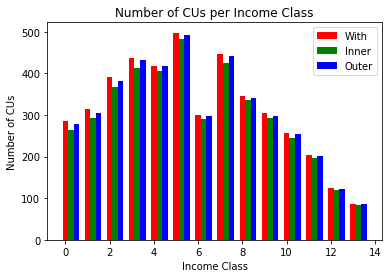

In [32]:
plt.close()
n_groups = 4
values1 = inclassExpenses.INCLASS.value_counts().values
values2 = clean1.INCLASS.value_counts().values
values3 = clean2.INCLASS.value_counts().values

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 1
 
rects1 = plt.bar(inclassExpenses.INCLASS.value_counts().index -1, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='With')
 
rects2 = plt.bar(clean1.INCLASS.value_counts().index -1 + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Inner')

rects3 = plt.bar(clean2.INCLASS.value_counts().index - 1 + bar_width*2, values3, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Outer')

plt.xlabel('Income Class')
plt.ylabel('Number of CUs')
plt.title('Number of CUs per Income Class')
plt.legend()
plt.show()

The average percent change between with and without outliers: 2.59%


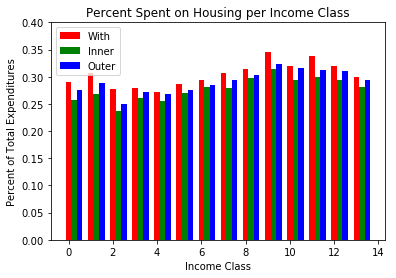

In [33]:
n_groups = 4
values1 = percentages.iHousing
values2 = cleanPercentages1.iHousing
values3 = cleanPercentages2.iHousing

print("The average percent change between with and without outliers: "+str(round((values1-values2).mean()*100,2))+"%")

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 1
 
rects1 = plt.bar(percentages.index, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='With')
 
rects2 = plt.bar(cleanPercentages1.index + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Inner')

rects3 = plt.bar(cleanPercentages2.index + bar_width*2, values3, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Outer')

plt.xlabel('Income Class')
plt.ylabel('Percent of Total Expenditures')
plt.title('Percent Spent on Housing per Income Class')
plt.ylim(0,.4)
plt.legend()
plt.show()

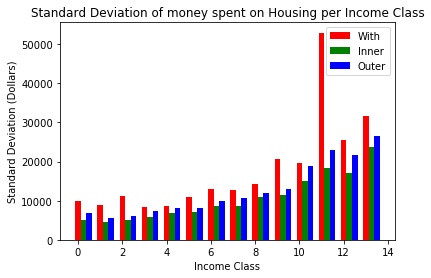

In [34]:
n_groups = 4
values1 = inclassSD.iHousing
values2 = inclassClean1SD.iHousing
values3 = inclassClean2SD.iHousing

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 1
 
rects1 = plt.bar(percentages.index, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='With')
 
rects2 = plt.bar(cleanPercentages1.index + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Inner')

rects3 = plt.bar(cleanPercentages2.index + bar_width*2, values3, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Outer')

plt.xlabel('Income Class')
plt.ylabel('Standard Deviation (Dollars)')
plt.title('Standard Deviation of money spent on Housing per Income Class')
plt.legend()
plt.show()

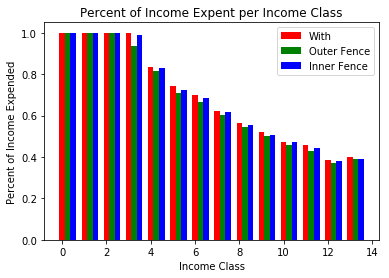

In [35]:
n_groups = 3
values1 = percentages.ExpInc
values2 = cleanPercentages1.ExpInc
values3 = cleanPercentages2.ExpInc

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 1
 
rects1 = plt.bar(percentages.index, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='With')
 
rects2 = plt.bar(cleanPercentages1.index + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Outer Fence')

rects3 = plt.bar(cleanPercentages2.index + bar_width*2, values3, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Inner Fence')
 
plt.xlabel('Income Class')
plt.ylabel('Percent of Income Expended')
plt.title('Percent of Income Expent per Income Class')
plt.legend()
plt.show()

# Least squares polynomial fit
any value that would cause a person to expend over 100% of their income is truncated to 100%

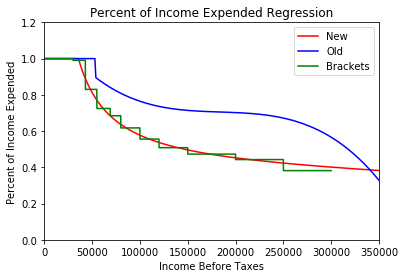

In [36]:
# cleanPercentages2.ExpInc[3:]
cleanReg = clean2[["FINCBTXM","iTotalExp"]]
cleanReg = cleanReg.loc[clean2.FINCBTXM > 0]
cleanReg = cleanReg.loc[cleanReg.iTotalExp > 0]
cleanReg
def getExpendPercent(income):
    if income <= 0:
        return(1)
    coefficients = np.polyfit(cleanReg.FINCBTXM, cleanReg.iTotalExp, deg = 3)
    p = np.poly1d(coefficients)
    np.seterr(divide='ignore')
    percent = p(income)/income
    if percent > 1:
        percent = 1
    return(percent)

x = range(0,360000,1000)
x2 = range(0,360000,1000)
y =[]
y2 =[]
def oldRegression(income):
    if income > 53000:
        output = ((-7.6108*(10**(-17)))*(income**3))+((4.2009*(10**(-11)))*(income**2))+((-7.90256*(10**-6))*income)+1.21112
    else:
        output = 1
    return(output)


for bracket in range(0,360000,1000):
    y.append(getExpendPercent(bracket))
    y2.append(oldRegression(bracket))
# plt.plot(inclassCleanAverages2.FINCBTXM,cleanPercentages2.ExpInc)
plt.plot(x,y, color = "r", label="New")
plt.plot(x2,y2, color = "b", label = "Old")
x3 = range(0,300000)
y3 = np.repeat(cleanPercentages2.ExpInc[0:len(cleanPercentages2)-1], [11000,9000,10000,13000,12000,14000,11000,20000,20000,30000,50000,50000,50000])
plt.plot(x3,y3, color = "g", label = "Brackets")
plt.title("Percent of Income Expended Regression")
plt.xlabel("Income Before Taxes")
plt.ylabel("Percent of Income Expended")
plt.xlim(0,350000)
plt.ylim(0,1.2)
plt.legend()
plt.show()

# Examples of Users

In [37]:
usersIncome = [30000, 60000, 90000, 120000, 250000]
def getIncomeBracket(income):
    for bracket in range(len(incomeBrackets)-2,0,-1):
        if income > incomeBrackets[bracket]:
            return bracket
            

exampleExpenses = pd.DataFrame(columns = cleanPercentages2.columns, index = range(len(usersIncome)))
for user in usersIncome:
    userBracket = getIncomeBracket(user)
    userExpendAmount = getExpendPercent(user) * user
    userBaseExpenses = (cleanPercentages2.loc[userBracket]*userExpendAmount)/12
    exampleExpenses.loc[usersIncome.index(user)] = userBaseExpenses

exampleExpenses.index = usersIncome


exampleExpenses

,iFoodAtHome,iFoodAway,iHousing,iUtilites,iClothingAndBeauty,iTransportation,iHealthcare,iEntertainment,iMiscellaneous,iCharitableAndFamilyGiving,iInsurance,iEducation,iHousingPrinciple,ExpInc
30000,368.472,155.263,625.286,271.11,61.0504,481.367,281.064,151.323,69.5026,65.1252,11.2247,13.8623,54.6516,2500
60000,435.366,224.357,1016.3,351.776,113.419,731.636,446.642,189.031,89.2411,140.954,26.8773,65.2973,154.335,2664.4
90000,498.53,274.817,1334.38,396.053,125.933,965.497,487.727,283.962,74.2435,214.612,47.419,49.9139,223.177,2797.12
120000,585.186,362.193,1630.33,463.735,165.418,1081.56,578.847,348.269,96.6542,250.337,55.6988,78.7017,325.287,2985.62
250000,719.322,585.263,2754.34,547.098,281.815,1710.56,690.933,536.642,75.1189,684.467,64.7164,742.678,572.4,3904.6


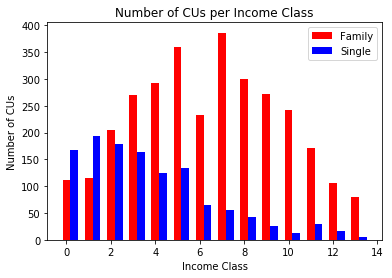

In [38]:
plt.close()
n_groups = 3
values1 = cleanFamily.INCLASS.value_counts().values
values2 = cleanSingle.INCLASS.value_counts().values

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 1

 
rects1 = plt.bar(cleanFamily.INCLASS.value_counts().index -1, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Family')

rects2 = plt.bar(cleanSingle.INCLASS.value_counts().index - 1 + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Single')

plt.xlabel('Income Class')
plt.ylabel('Number of CUs')
plt.title('Number of CUs per Income Class')
plt.legend()
plt.show()

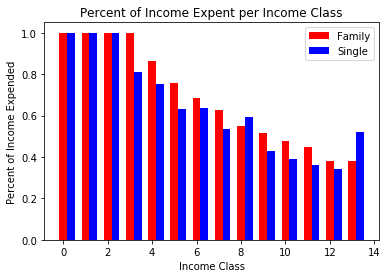

In [39]:
n_groups = 3
values1 = cleanPercentagesFamily.ExpInc
values2 = cleanPercentagesSingle.ExpInc

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 1
 
rects1 = plt.bar(cleanPercentagesFamily.index, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Family')
 
rects2 = plt.bar(cleanPercentagesSingle.index + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Single')

 
plt.xlabel('Income Class')
plt.ylabel('Percent of Income Expended')
plt.title('Percent of Income Expent per Income Class')
plt.legend()
plt.show()

### Looking at the Family vs Single Healthcare costs
Note: The higher income brackets are not statistically significant for the Single people because there are so few observations (<50)

0.10522536948589799
0.09318305847775236


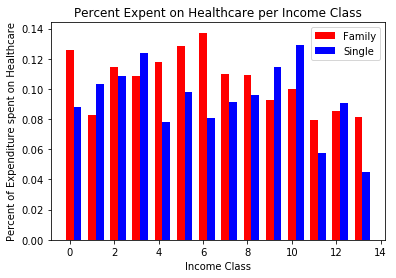

In [40]:
print(cleanPercentagesFamily.iHealthcare.mean())
print(cleanPercentagesSingle.iHealthcare.mean())

n_groups = 3
values1 = cleanPercentagesFamily.iHealthcare
values2 = cleanPercentagesSingle.iHealthcare

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 1
 
rects1 = plt.bar(cleanPercentagesFamily.index, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Family')
 
rects2 = plt.bar(cleanPercentagesSingle.index + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Single')

 
plt.xlabel('Income Class')
plt.ylabel('Percent of Expenditure spent on Healthcare')
plt.title('Percent Expent on Healthcare per Income Class')
plt.legend()
plt.show()

### Looking at the Family vs Single Transportation costs
Note: The higher income brackets are not statistically significant for the Single people because there are so few observations (<50)

0.19468700282741078
0.19551407877641624


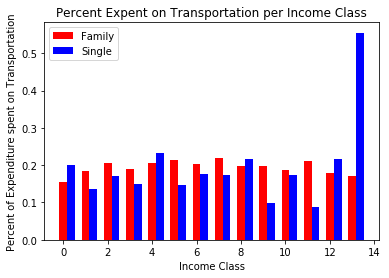

In [41]:
print(cleanPercentagesFamily.iTransportation.mean())
print(cleanPercentagesSingle.iTransportation.mean())

n_groups = 3
values1 = cleanPercentagesFamily.iTransportation
values2 = cleanPercentagesSingle.iTransportation

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 1
 
rects1 = plt.bar(cleanPercentagesFamily.index, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Family')
 
rects2 = plt.bar(cleanPercentagesSingle.index + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Single')

 
plt.xlabel('Income Class')
plt.ylabel('Percent of Expenditure spent on Transportation')
plt.title('Percent Expent on Transportation per Income Class')
plt.legend()
plt.show()